# **Playlist Recommender**
### How many times were you playing music around friends/family and don't know which song to play next maintains the same vibe and energy? The goal of this model is to create a machine learning model that recommends a list of songs that best fit any song you input into.
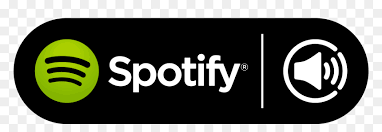

# 1. Importing libraries
#### Let's first load all of the libraries necessary

In [ ]:
import os
import warnings
warnings.simplefilter("ignore", UserWarning)

import numpy as np
import pandas as pd
import seaborn as sns
#!pip install plotly
import plotly.express as px 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

#!pip install spotipy
import spotipy

from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
from spotipy.oauth2 import SpotifyClientCredentials
from collections import defaultdict
 
from sklearn.metrics import euclidean_distances
from scipy.spatial.distance import cdist
import difflib

# 2. Loading data

In [ ]:
df_main = pd.read_csv("/kaggle/input/spotify-1million-tracks/spotify_data.csv").drop(['Unnamed: 0'],axis = 1)

# 3. Exploratory Data Analysis (EDA)

## 3.1 Data Description

#### We'll first create a custom function that shows us the data type, % missing data, and number of unique values for each feature in the dataframe

In [ ]:
def df_explore(df):
    missing = pd.DataFrame((df.isna().sum()/df.shape[0])*100).reset_index().rename(columns={'index': 'column',0:'%_missing'}).sort_values(by = '%_missing',ascending=False)
    nunique = pd.DataFrame(df.nunique()).reset_index().rename(columns={'index': 'column',0:'nunique'}).sort_values(by = 'nunique',ascending=False)
    dtypes = pd.DataFrame(df.dtypes).reset_index().rename(columns={'index': 'column',0:'dtype'})
    return pd.merge(pd.merge(dtypes,missing,on='column'),nunique,on='column',how='left').sort_values(by='%_missing',ascending=False).sort_values(by = 'nunique', ascending = False)
print(df_main.shape)

df_explore(df_main)

## 3.2 Data Cleanup
#### Since there is very little missing data we can omit those rows

In [ ]:
df_main = df_main.dropna(axis = 0)

## 3.3 Visual Insights

### 3.3.1 Top 5 artists based on popularity

In [ ]:
top10_artists = df_main.nlargest(5, 'popularity')
fig = px.bar(top10_artists, x='artist_name', y=['popularity'], barmode='group')
fig.update_layout(yaxis_title="popularity", xaxis_title="artist", title = f'Top 5 artists based on popularity')
fig.update_layout(title={'x': 0.5, 'xanchor': 'center'})
fig.show()

### 3.3.2 Top 5 most popular artists and their associated audio features

In [ ]:
fig = px.bar(df_main.nlargest(5, 'popularity'), x='artist_name', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.update_layout(yaxis_title="audio feature", xaxis_title="artist", title = f'Top 5 artists based on popularity and their audio features')
fig.update_layout(title={'x': 0.5, 'xanchor': 'center'})
fig.show()

### 3.3.3 Top 5 genres based on popularity

In [ ]:
fig = px.bar(df_main.nlargest(10, 'popularity'), x='genre', y=['popularity'], barmode='group')
fig.update_layout(yaxis_title="popularity", xaxis_title="genre", title = f'Top 5 genres based on popularity')
fig.update_layout(title={'x': 0.5, 'xanchor': 'center'})
fig.show()

### 3.3.4 Top 5 most popular genres and their associated audio features

In [ ]:
fig = px.bar(df_main.nlargest(10, 'popularity'), x='genre', y=['valence', 'energy', 'danceability', 'acousticness'], barmode='group')
fig.update_layout(yaxis_title="audio feature", xaxis_title="genre", title = f'Top 5 most popular genres and their associated audio features')
fig.update_layout(title={'x': 0.5, 'xanchor': 'center'})
fig.show()

# 4. K-means Clustering
#### Clustering is a technique to divide data into different groups with the goal to identify significant/meaningful groups of data.
#### K-means works best in this case because it divides the data into K clusters by minimizing the sum of the squared distances of each record to the mean of its assigned cluster. Finding the clusters that are best seperated.
#### This way we can see how seperated our data clusters are. First we will cluster by genre and then by audio features


## 4.1 Clustering by genre

In [ ]:
# filtering on genre and numeric features
genres = df_main[['mode', 'genre', 'acousticness', 'danceability', 'duration_ms',
      'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness',
      'tempo', 'valence', 'popularity', 'key','time_signature']]

cluster_pipeline = Pipeline([('scaler', StandardScaler()), ('kmeans', KMeans(n_clusters=10))])
cluster_pipeline.fit(genres.select_dtypes(np.number))
genres['cluster'] = cluster_pipeline.predict(genres.select_dtypes(np.number))

### 4.1.2 Visualizing the clusters with tsne

In [ ]:
tsne_pipeline = Pipeline([('scaler', StandardScaler()), ('tsne', TSNE(n_components=2, verbose=0))])
genre_embedding = tsne_pipeline.fit_transform(genres_data.select_dtypes(np.number))
projection = pd.DataFrame(columns=['x', 'y'], data=genre_embedding)
projection['genre'] = genres['genres']
projection['cluster'] = genres['cluster']

fig = px.scatter(projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'genre'])
fig.show()

#### As expected, we have data points with similar genres that are located close to each other

## 4.2 Clustering by songs

In [ ]:
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=20, 
                                   verbose=False))], verbose=False)

X = df_main.select_dtypes(np.number)
audio_features = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
df_main['cluster_label'] = song_cluster_labels

### 4.2.1 Visualizing the clusters with PCA

In [ ]:
from sklearn.decomposition import PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = df_main['name']
projection['cluster'] = df_main['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

#### We can see that our audio feature data is not as seperated, but nonetheless they are distinct clusters

# 5. Building the model

#### Since we observed that similar genres and tracks's audio features are clustered close together, we can surmise that they sound similar.
#### The basis of our model will be using closely clustered audio feature datapoints to determine which songs are the most similar to recommend to play next.

## 5.1 Initializing spotify API client credentials
#### We will load spotipy which allows us to use the API client credentials to access data from Spotify's database

In [ ]:
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id='client_id', client_secret='client_secret'))

## 5.2 Define functions for the recommender model
#### We will start by creating a few functions that will be used in the final model

### 5.2.1 Getting song audio features
#### This function is to pull the audio features for a given track needed to eventually be used to recommend songs

In [ ]:
def get_song(artist_name,name, year):
    song_info = defaultdict()
    results = sp.search(q= 'track: {} artists.str.contains({})'.format(name,year), limit=1)
    if results['tracks']['items'] == []:
        return None

    results = results['tracks']['items'][0]
    track_id = results['id']
    audio_features = sp.audio_features(track_id)[0]
    
    song_info['artist_name'] = [artist_name]
    song_info['track_name'] = [track_name]
    song_info['year'] = [year]
    song_info['duration_ms'] = [results['duration_ms']]
    song_info['popularity'] = [results['popularity']]

    for key, value in audio_features.items():
        song_info[key] = value

    return pd.DataFrame(song_info)


### 5.2.2 Getting song audio information
#### This function is to pull the information such as track name, year, and artist name for a given song¶

In [ ]:
def get_song_info(song, spotify_data):
    
    try:
        song_info = spotify_data[(spotify_data['artist_name'] == song['artist_name'])&(spotify_data['track_name'] == song['track_name']) 
                                & (spotify_data['year'] == song['year'])].iloc[0]
        return song_info
    
    except IndexError:
        return get_song(song['artist_name'],song['track_name'], song['year'])

### 5.2.3 Generating the median for each audio feature
#### In order to recommend a list of songs based on a given one, we need to use audio features. The best way to do this is to caculate the median of the value for each feature.

In [ ]:
def get_median_vector(song_list, spotify_data):
    
    song_vectors = []
    
    for song in song_list:
        song_info = get_song_info(song, spotify_data)
        if song_info is None:
            print('Warning: {} does not exist in Spotify or in database'.format(song['name']))
            continue
        song_vector = song_info[audio_features].values
        song_vectors.append(song_vector)  
    
    song_matrix = np.array(list(song_vectors))
    return np.median(song_matrix, axis=0)

### 5.2.4 Creating a dictionary that will be our input in the final model

In [ ]:
def flatten_dict(dict_list):
    
    flattened_dict = defaultdict()
    for key in dict_list[0].keys():
        flattened_dict[key] = []
    
    for dictionary in dict_list:
        for key, value in dictionary.items():
            flattened_dict[key].append(value)
    return flattened_dict

## 6.2 Building recommender model

In [ ]:
def song_recommender(song_list, spotify_data,n_songs = 15):
    
    metadata_cols = ['artist_name','track_name','year']
    song_dict = flatten_dict(song_list)
    
    song_mean = get_median_vector(song_list, spotify_data)
    scaler = song_cluster_pipeline.steps[0][1]
    scaled_data = scaler.transform(spotify_data[audio_features])
    scaled_song_center = scaler.transform(song_mean.reshape(1, -1))
    distances = cdist(scaled_song_center, scaled_data, 'cosine')
    index = list(np.argsort(distances)[:, :n_songs][0])
    
    rec_songs = spotify_data.iloc[index]
    rec_songs = rec_songs[~rec_songs['track_name'].isin(song_dict['track_name'])]
    return rec_songs[metadata_cols].reset_index(drop=True)

# 7. Results

In [ ]:
song_recommender([{'artist_name': "50 Cent",
                   'track_name': "Best Friend",
                   'year':2005}],  df_main)